<a href="https://colab.research.google.com/github/abnan/ODECME/blob/master/ODECME_ADNI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install simpleitk

     |████████████████████████████████| 42.5MB 68kB/s 


In [2]:
from skimage import io
import numpy as np
import math
import matplotlib.pyplot as plt
import torch
import shutil
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from skimage.transform import pyramid_gaussian
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.filters import sobel
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.morphology import square
from skimage.morphology import dilation
from torch.autograd import Function
import pandas as pd
import cv2
import time
from IPython.display import clear_output
from PIL import Image
from torch.optim.lr_scheduler import StepLR
import SimpleITK as sitk
from skimage.metrics import structural_similarity, mean_squared_error, peak_signal_noise_ratio
from pathlib import Path
from scipy.ndimage import zoom
Image.MAX_IMAGE_PIXELS = None

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
B = torch.zeros(7,4,4).to(device)
B[0,0,3] = 1.0
B[1,1,3] = 1.0
B[2,2,3] = 1.0
B[3,1,2], B[3,2,1] = -1.0, 1.0
B[4,0,2], B[4,2,0] = 1.0, -1.0
B[5,0,1], B[5,1,0] = -1.0, 1.0
B[6,3,3] = -1

def MatrixExp(vr,vi):
    Cr = torch.sum(B*vr,0)
    Ci = torch.sum(B*vi,0)

    A1r,A2r,A1i,A2i=[],[],[],[]
    A1r.append(torch.eye(4).to(device))
    A1i.append(torch.zeros((4,4)).to(device))
    A2r.append(torch.eye(4).to(device))
    A2i.append(torch.zeros((4,4)).to(device))

    Hr = torch.eye(4).to(device)
    Hi = torch.zeros((4,4)).to(device)
    Hinvr = torch.eye(4).to(device)
    Hinvi = torch.zeros((4,4)).to(device)

    for i in torch.arange(1,10):
        A1r.append(torch.mm(A1r[i-1]/i,Cr)-torch.mm(A1i[i-1]/i,Ci))
        A1i.append(torch.mm(A1r[i-1]/i,Ci)+torch.mm(A1i[i-1]/i,Cr))
        Hr += A1r[i]
        Hi += A1i[i]

        A2r.append(torch.mm(A2r[i-1]/i,-Cr)-torch.mm(A2i[i-1]/i,-Ci))
        A2i.append(torch.mm(A2r[i-1]/i,-Ci)+torch.mm(A2i[i-1]/i,-Cr))
        Hinvr += A2r[i]
        Hinvi += A2i[i]
    return Hr,Hi,Hinvr,Hinvi    


In [4]:
n_neurons = 100
class MINE(nn.Module): #https://arxiv.org/abs/1801.04062
  def __init__(self):
    super(MINE, self).__init__()
    self.fc1 = nn.Linear(2*nChannel, n_neurons)
    self.fc2 = nn.Linear(n_neurons, n_neurons)
    self.fc3 = nn.Linear(n_neurons, 1)
    self.bsize = 1 # 1 may be sufficient

  def forward(self, x, ind):
    x = x.view(x.size()[0]*x.size()[1]*x.size()[2],x.size()[3])
    MI_lb=0.0
    for i in range(self.bsize):
      ind_perm = ind[torch.randperm(len(ind))]
      z1 = self.fc3(F.relu(self.fc2(F.relu(self.fc1(x[ind,:])))))
      z2 = self.fc3(F.relu(self.fc2(F.relu(self.fc1(torch.cat((x[ind,0:nChannel],x[ind_perm,nChannel:2*nChannel]),1))))))

      MI_lb += torch.mean(z1) - torch.log(torch.mean(torch.exp(z2)))
    
    return MI_lb/self.bsize

In [5]:
def PerspectiveComplexWarping(I, Hr, Hi, xv, yv, zv):
    xr = xv*Hr[0,0]+yv*Hr[0,1]+zv*Hr[0,2]+Hr[0,3]
    yr = xv*Hr[1,0]+yv*Hr[1,1]+zv*Hr[1,2]+Hr[1,3]
    zr = xv*Hr[2,0]+yv*Hr[2,1]+zv*Hr[2,2]+Hr[2,3]
    tr = xv*Hr[3,0]+yv*Hr[3,1]+zv*Hr[3,2]+Hr[3,3]

    xi = xv*Hi[0,0]+yv*Hi[0,1]+zv*Hi[0,2]+Hi[0,3]
    yi = xv*Hi[1,0]+yv*Hi[1,1]+zv*Hi[1,2]+Hi[1,3]
    zi = xv*Hi[2,0]+yv*Hi[2,1]+zv*Hi[2,2]+Hi[2,3]
    ti = xv*Hi[3,0]+yv*Hi[3,1]+zv*Hi[3,2]+Hi[3,3]
    
    xvt = (xr*tr+xi*ti)/(tr**2+ti**2)
    yvt = (yr*tr+yi*ti)/(tr**2+ti**2)
    zvt = (zr*tr+zi*ti)/(tr**2+ti**2)
    J = F.grid_sample(I,torch.stack([xvt,yvt,zvt],3).unsqueeze(0),align_corners=False).squeeze()
    return J


In [6]:
def multi_resolution_MINE_loss():
    loss=0.0
    params = ode_net()
    for s in np.arange(L-1,-1,-1):
        Hr,Hi,Hinvr,Hinvi = MatrixExp(params[0][s].view(7,1,1), params[1][s].view(7,1,1))
        
        Jw_ = PerspectiveComplexWarping(J_lst[s].unsqueeze(0).unsqueeze(0), Hr, Hi, xyz_lst[s][:,:,:,0], xyz_lst[s][:,:,:,1], xyz_lst[s][:,:,:,2]).squeeze()
        mi = mine_net(torch.stack([I_lst[s],Jw_],3),ind_lst[s])
        
        Iw_ = PerspectiveComplexWarping(I_lst[s].unsqueeze(0).unsqueeze(0), Hinvr, Hinvi, xyz_lst[s][:,:,:,0], xyz_lst[s][:,:,:,1], xyz_lst[s][:,:,:,2]).squeeze()
        mi_inv = mine_net(torch.stack([Iw_,J_lst[s]],3),ind_lst[s])
        loss = loss - (1./(2*L))*(mi+mi_inv)
    return loss

In [7]:
n_neurons = 100
activation = torch.tanh
class ODENet(nn.Module):

  def __init__(self):
    super(ODENet, self).__init__()
    self.fc1 = nn.Linear(8, n_neurons)
    self.fc2 = nn.Linear(n_neurons, 7)
    self.vr = torch.nn.Parameter(torch.zeros(7).to(device), requires_grad=True)
    self.vi = torch.nn.Parameter(torch.tensor(np.random.uniform(-1e-6,1e-6,(7)),dtype=torch.float32).to(device), requires_grad=True)
    self.f = 1./torch.pow(downscale, torch.linspace(0,L-1,L)).to(device)
    
    self.fc1.weight.data.fill_(0.0)
    self.fc1.bias.data.fill_(0.0)

    self.fc2.weight.data.fill_(0.0)
    self.fc2.bias.data.fill_(0.0)
    
  def forward(self): # Runge-Kutta method

    h = self.f[0:L-1] - self.f[1:L]
    params_r = torch.zeros(L,7).to(device)
    params_r[L-1] = self.vr
    for i in np.arange(L-2,-1,-1):
      k1 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1),params_r[i+1])))))
      k2 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1)+(1.0/3.0)*h[i],params_r[i+1]+(1.0/3.0)*k1)))))
      k3 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1)+(2.0/3.0)*h[i],params_r[i+1]-(1.0/3.0)*k1+k2)))))
      k4 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i].view(1),params_r[i+1]+k1-k2+k3)))))
      params_r[i] = params_r[i+1] + (1.0/8.0)*(k1+3.0*k2+3.0*k3+k4)


    params_i = torch.zeros(L,7).to(device)
    params_i[L-1] = self.vi
    for i in np.arange(L-2,-1,-1):
      k1 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1),params_i[i+1])))))
      k2 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1)+(1.0/3.0)*h[i],params_i[i+1]+(1.0/3.0)*k1)))))
      k3 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i+1].view(1)+(2.0/3.0)*h[i],params_i[i+1]-(1.0/3.0)*k1+k2)))))
      k4 = h[i]*self.fc2(activation(self.fc1(torch.cat((self.f[i].view(1),params_i[i+1]+k1-k2+k3)))))
      params_i[i] = params_i[i+1] + (1.0/8.0)*(k1+3.0*k2+3.0*k3+k4)
    return params_r, params_i


In [18]:
referenceImageFileName = "ADNI_141_S_1255_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20070411124635135_S25887_I48608.nii"
fixed_image =  sitk.ReadImage(referenceImageFileName, sitk.sitkFloat32)
fixed_image_np = sitk.GetArrayFromImage(fixed_image)
fixed_image_np = fixed_image_np/np.max(fixed_image_np)


inputImageFileName = "ADNI_032_S_0677_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080220105435721_S19889_I90942.nii"
moving_image =  sitk.ReadImage(inputImageFileName, sitk.sitkFloat32)
moving_image_np = sitk.GetArrayFromImage(moving_image)
moving_image_np = zoom(moving_image_np, (1, 192/moving_image_np.shape[1], 192/moving_image_np.shape[2]))
moving_image_np = moving_image_np/np.max(moving_image_np)

In [19]:
print(fixed_image_np.shape, moving_image_np.shape)

(160, 192, 192) (160, 192, 192)


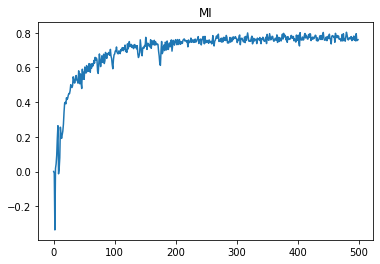

In [20]:
height, width, depth = fixed_image_np.shape

downscale = 2
nChannel=1
pyramid_I = tuple(pyramid_gaussian(fixed_image_np, downscale=downscale, multichannel=False))
pyramid_J = tuple(pyramid_gaussian(moving_image_np, downscale=downscale, multichannel=False))

L = 5 # where registration starts (at the coarsest resolution)
sampling = 0.1
# create a list of necessary objects you will need and commit to GPU
I_lst,J_lst,xyz_lst,ind_lst=[],[],[],[]
for s in range(L):
    I_, J_ = torch.tensor(pyramid_I[s].astype(np.float32)).to(device), torch.tensor(pyramid_J[s].astype(np.float32)).to(device)
    I_lst.append(I_)
    J_lst.append(J_)
    d_, h_, w_= I_lst[s].shape[0], I_lst[s].shape[1], I_lst[s].shape[2]
    ind_ = torch.randperm(h_*w_*d_)[:int(h_*w_*d_*sampling)]
    ind_lst.append(ind_)
    z_, y_, x_ = torch.meshgrid([torch.arange(0,d_).float().to(device), torch.arange(0,h_).float().to(device), torch.arange(0,w_).float().to(device)])
    z_, y_, x_ = 2.0*z_/(d_-1) - 1.0, 2.0*y_/(h_-1) - 1.0, 2.0*x_/(w_-1) - 1.0
    xyz_ = torch.stack([x_,y_,z_],3)
    xyz_lst.append(xyz_)


ode_net = ODENet().to(device)

mine_net = MINE().to(device)
optimizer = optim.Adam([{'params': mine_net.parameters(), 'lr': 1e-1},
                        {'params': ode_net.parameters(), 'lr': 1e-2}], amsgrad=True)
mi_list = []
scheduler = StepLR(optimizer, step_size=100, gamma=0.5)

for itr in range(500):
    optimizer.zero_grad()
    loss = multi_resolution_MINE_loss()
    mi_list.append(-loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()
    loss,cond = None, None
    clear_output(wait=True)
    plt.plot(mi_list)
    plt.title("MI")
    plt.show()

In [21]:
params = ode_net()
Hr,Hi,Hinvr,Hinvi = MatrixExp(params[0][0].view(7,1,1), params[1][0].view(7,1,1))

J_t = torch.tensor(moving_image_np).to(device)
Jw_ = PerspectiveComplexWarping(J_lst[0].unsqueeze(0).unsqueeze(0), Hr, Hi, xyz_lst[0][:,:,:,0], xyz_lst[0][:,:,:,1], xyz_lst[0][:,:,:,2]).squeeze()
res = Jw_.detach().cpu().numpy()

In [22]:
print("SSIM Before:", structural_similarity(fixed_image_np, moving_image_np), "After:", structural_similarity(fixed_image_np, res))
print("PSNR Before:", peak_signal_noise_ratio(fixed_image_np, moving_image_np), "After:", peak_signal_noise_ratio(fixed_image_np, res))
print("SSD Before:", mean_squared_error(fixed_image_np, moving_image_np), "After:", mean_squared_error(fixed_image_np, res))

SSIM Before: 0.5334567256414652 After: 0.661804557429359
PSNR Before: 17.778220352432562 After: 19.453476234000433
SSD Before: 0.016679305554400527 After: 0.011341026796734818


Difference before:


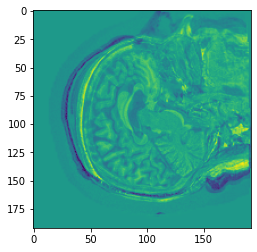

Difference after:


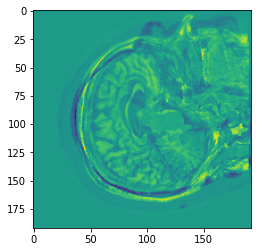

In [23]:
diff_before = fixed_image_np-moving_image_np
diff_after = fixed_image_np-res
slice_num = 75
print("Difference before:")
# plt.figure(figsize=(10,10))
plt.imshow(diff_before[slice_num])
plt.show()
# plt.figure(figsize=(10,10))
print("Difference after:")
plt.imshow(diff_after[slice_num])
plt.show()

(192, 192, 160)


(-0.5, 159.5, 191.5, -0.5)

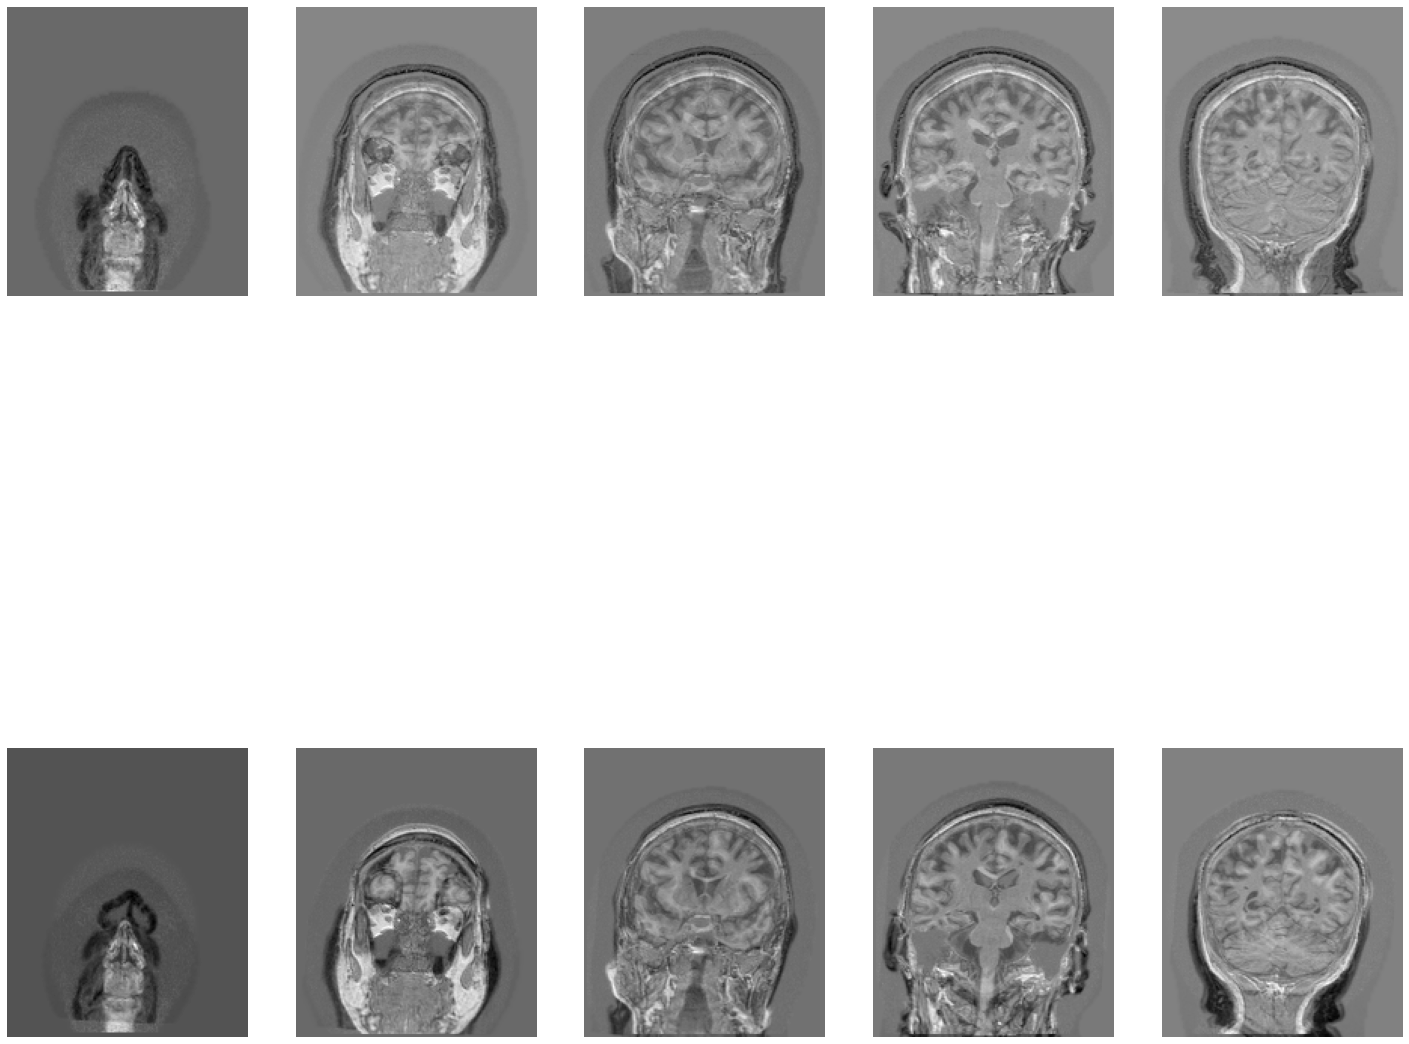

In [24]:
before = diff_before.swapaxes(1,0).swapaxes(-2,-1)[...,::-1]
after = diff_after.swapaxes(1,0).swapaxes(-2,-1)[...,::-1]
print(before.shape)
plt.figure(figsize=(25,25))

plt.subplot(2, 5, 1)
plt.imshow(before[20], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 2)
plt.imshow(before[50], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 3)
plt.imshow(before[75], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 4)
plt.imshow(before[100], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 5)
plt.imshow(before[125], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 6)
plt.imshow(after[20], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 7)
plt.imshow(after[50], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 8)
plt.imshow(after[75], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 9)
plt.imshow(after[100], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 10)
plt.imshow(after[125], cmap='gray')
plt.axis('off')

(160, 192, 192)


(-0.5, 191.5, 191.5, -0.5)

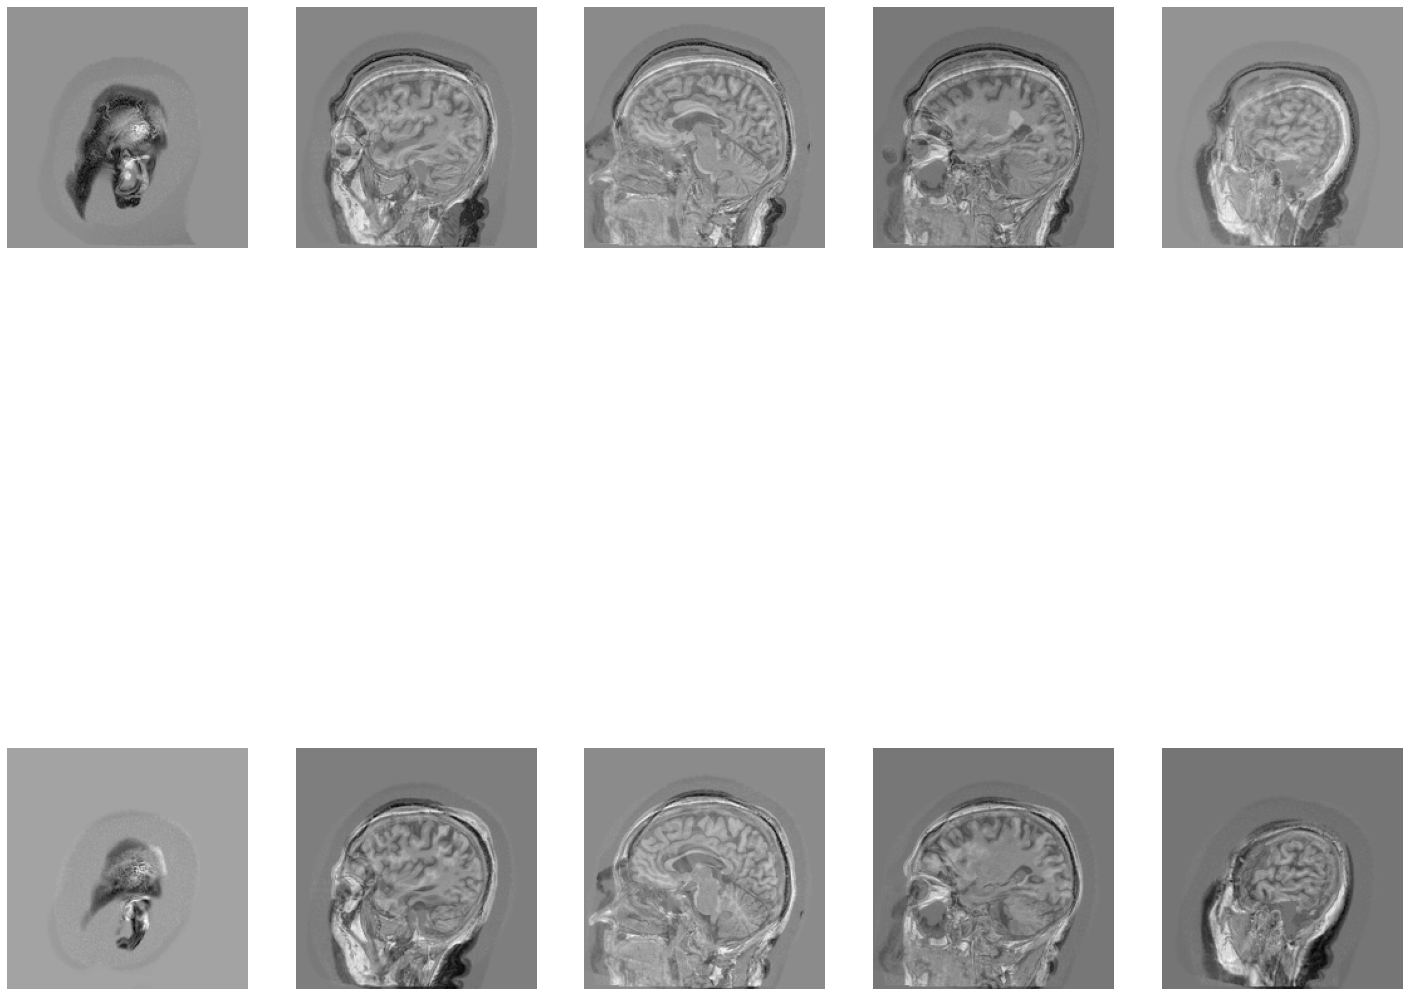

In [25]:
before = diff_before.swapaxes(1,2)
after = diff_after.swapaxes(1,2)
print(before.shape)
plt.figure(figsize=(25,25))

plt.subplot(2, 5, 1)
plt.imshow(before[20], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 2)
plt.imshow(before[50], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 3)
plt.imshow(before[75], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 4)
plt.imshow(before[100], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 5)
plt.imshow(before[125], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 6)
plt.imshow(after[20], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 7)
plt.imshow(after[50], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 8)
plt.imshow(after[75], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 9)
plt.imshow(after[100], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 10)
plt.imshow(after[125], cmap='gray')
plt.axis('off')

(192, 192, 160)


(-0.5, 159.5, 191.5, -0.5)

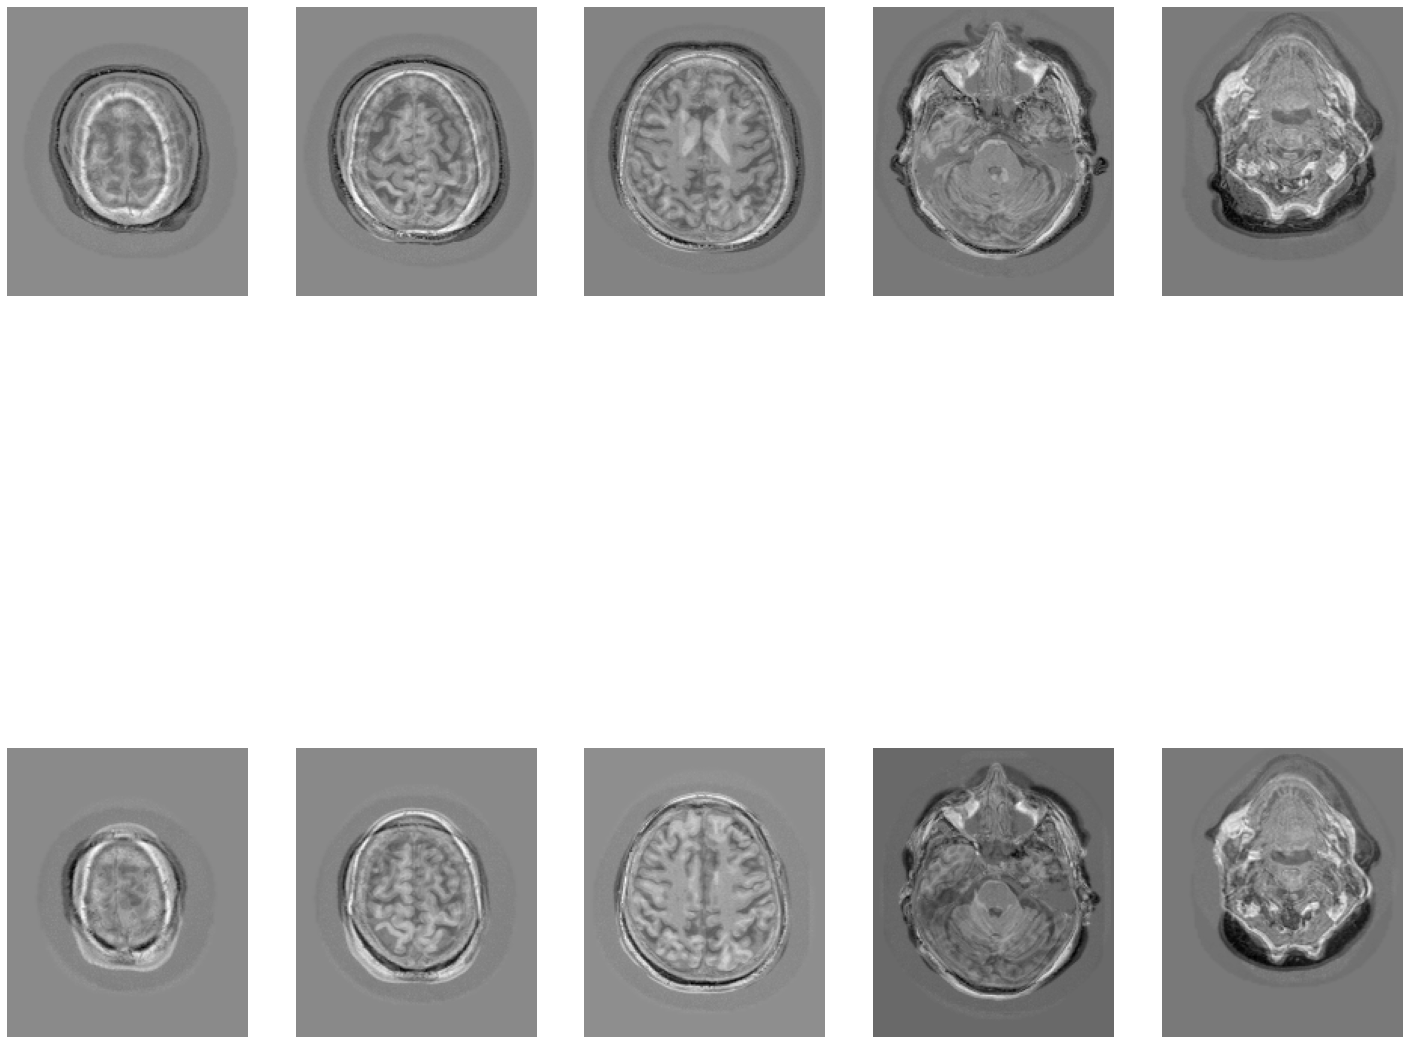

In [26]:
before = diff_before.swapaxes(0, 2)
after = diff_after.swapaxes(0, 2)
print(before.shape)
plt.figure(figsize=(25,25))

plt.subplot(2, 5, 1)
plt.imshow(before[50], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 2)
plt.imshow(before[60], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 3)
plt.imshow(before[75], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 4)
plt.imshow(before[125], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 5)
plt.imshow(before[175], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 6)
plt.imshow(after[50], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 7)
plt.imshow(after[60], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 8)
plt.imshow(after[75], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 9)
plt.imshow(after[125], cmap='gray')
plt.axis('off')

plt.subplot(2, 5, 10)
plt.imshow(after[175], cmap='gray')
plt.axis('off')